✅ Week column successfully parsed and set as index.
Skewness: -0.004190386687384682
✅ Skewness is acceptable. No transformation applied.
✅ Best rolling window (weekly): 6


[I 2025-04-07 20:34:03,916] A new study created in memory with name: no-name-4551e2fe-236c-4e5f-bc5a-71851d2e1dfd
[I 2025-04-07 20:34:03,965] Trial 0 finished with value: 9.460896223837118 and parameters: {'trend': 'mul', 'seasonal': None, 'seasonal_periods': 11}. Best is trial 0 with value: 9.460896223837118.
[I 2025-04-07 20:34:04,009] Trial 1 finished with value: 8.918617279955308 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 13}. Best is trial 1 with value: 8.918617279955308.
[I 2025-04-07 20:34:04,055] Trial 2 finished with value: 9.460896223837118 and parameters: {'trend': 'mul', 'seasonal': None, 'seasonal_periods': 31}. Best is trial 1 with value: 8.918617279955308.
[I 2025-04-07 20:34:04,290] Trial 3 finished with value: 11.536240390817786 and parameters: {'trend': 'mul', 'seasonal': 'mul', 'seasonal_periods': 25}. Best is trial 1 with value: 8.918617279955308.
[I 2025-04-07 20:34:04,457] Trial 4 finished with value: 8.750340092539952 and parameters: {

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 1
[LightGBM] [Info] Start training from score 202.821978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-07 20:34:17,582] Trial 5 finished with value: 13.13786665065711 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 7, 'learning_rate': 0.2375548416372696, 'iterations': 50, 'depth': 9, 'C': 3.2717551604973028, 'epsilon': 0.922325485192326, 'kernel': 'linear', 'n_neighbors': 14, 'weights': 'uniform'}. Best is trial 5 with value: 13.13786665065711.
[I 2025-04-07 20:34:17,624] Trial 6 finished with value: 13.14645741565274 and parameters: {'n_estimators': 250, 'max_depth': 18, 'min_samples_split': 5, 'learning_rate': 0.2773495520486858, 'iterations': 50, 'depth': 10, 'C': 7.6744816333818004, 'epsilon': 0.25302447122149546, 'kernel': 'rbf', 'n_neighbors': 11, 'weights': 'uniform'}. Best is trial 5 with value: 13.13786665065711.
[I 2025-04-07 20:34:17,664] Trial 7 finished with value: 13.145479875192583 and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 9, 'learning_rate': 0.24826779780027947, 'iterations': 200, 'depth': 3, 'C': 7

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 1
[LightGBM] [Info] Start training from score 202.821978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-07 20:34:17,740] Trial 9 finished with value: 13.176063777982671 and parameters: {'n_estimators': 300, 'max_depth': 18, 'min_samples_split': 9, 'learning_rate': 0.1146804082080394, 'iterations': 100, 'depth': 6, 'C': 6.095976278680899, 'epsilon': 0.19279746095608583, 'kernel': 'linear', 'n_neighbors': 4, 'weights': 'distance'}. Best is trial 5 with value: 13.13786665065711.
[I 2025-04-07 20:34:17,829] Trial 10 finished with value: 13.164566504003242 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 7, 'learning_rate': 0.2127737978583178, 'iterations': 250, 'depth': 8, 'C': 3.3721742999315607, 'epsilon': 0.957052181238468, 'kernel': 'linear', 'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 5 with value: 13.13786665065711.
[I 2025-04-07 20:34:17,919] Trial 11 finished with value: 13.157399738791073 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10, 'learning_rate': 0.21927924847698252, 'iterations': 300, 'depth': 4

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 1
[LightGBM] [Info] Start training from score 202.821978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-07 20:34:18,109] Trial 13 finished with value: 13.173609741877229 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'learning_rate': 0.19949087027537715, 'iterations': 250, 'depth': 8, 'C': 3.9053672218095565, 'epsilon': 0.6528412659736819, 'kernel': 'linear', 'n_neighbors': 15, 'weights': 'uniform'}. Best is trial 5 with value: 13.13786665065711.
[I 2025-04-07 20:34:18,206] Trial 14 finished with value: 13.148233456623021 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 7, 'learning_rate': 0.17870033240413363, 'iterations': 150, 'depth': 9, 'C': 2.3191241500560524, 'epsilon': 0.9610460591923456, 'kernel': 'poly', 'n_neighbors': 20, 'weights': 'distance'}. Best is trial 5 with value: 13.13786665065711.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 1
[LightGBM] [Info] Start training from score 202.821978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-07 20:34:18,299] Trial 15 finished with value: 13.152306447112688 and parameters: {'n_estimators': 150, 'max_depth': 17, 'min_samples_split': 3, 'learning_rate': 0.24897663403101927, 'iterations': 250, 'depth': 3, 'C': 9.896753396851185, 'epsilon': 0.3586899652830061, 'kernel': 'rbf', 'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 5 with value: 13.13786665065711.
[I 2025-04-07 20:34:18,394] Trial 16 finished with value: 13.152457596673383 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 6, 'learning_rate': 0.25219432605310654, 'iterations': 200, 'depth': 6, 'C': 4.8904612890906245, 'epsilon': 0.8007495983324308, 'kernel': 'linear', 'n_neighbors': 14, 'weights': 'uniform'}. Best is trial 5 with value: 13.13786665065711.
[I 2025-04-07 20:34:18,476] Trial 17 finished with value: 13.212036175929631 and parameters: {'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 8, 'learning_rate': 0.17571023031521865, 'iterations': 150, 'depth': 7,

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 1
[LightGBM] [Info] Start training from score 202.821978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-07 20:34:18,584] Trial 18 finished with value: 13.136829384433593 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 6, 'learning_rate': 0.2296032564952126, 'iterations': 300, 'depth': 4, 'C': 4.939844381759389, 'epsilon': 0.5870139145940428, 'kernel': 'rbf', 'n_neighbors': 13, 'weights': 'uniform'}. Best is trial 18 with value: 13.136829384433593.
[I 2025-04-07 20:34:18,692] Trial 19 finished with value: 13.128666129013505 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_split': 5, 'learning_rate': 0.28002456024481176, 'iterations': 300, 'depth': 5, 'C': 5.2183384662352434, 'epsilon': 0.6659890189644575, 'kernel': 'poly', 'n_neighbors': 2, 'weights': 'uniform'}. Best is trial 19 with value: 13.128666129013505.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 1
[LightGBM] [Info] Start training from score 202.821978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-07 20:34:19,616] A new study created in memory with name: no-name-597ba69b-a2d4-45d1-b9c4-10dc30535d6f


0:	learn: 33.9433866	total: 7.04ms	remaining: 1.4s
1:	learn: 31.0142155	total: 14.2ms	remaining: 1.41s
2:	learn: 28.5319955	total: 20.7ms	remaining: 1.36s
3:	learn: 26.3813516	total: 27.1ms	remaining: 1.33s
4:	learn: 24.6630554	total: 33.6ms	remaining: 1.31s
5:	learn: 23.3137313	total: 40.4ms	remaining: 1.31s
6:	learn: 22.3860113	total: 40.9ms	remaining: 1.13s
7:	learn: 21.4559891	total: 47.3ms	remaining: 1.13s
8:	learn: 20.7161175	total: 48.4ms	remaining: 1.03s
9:	learn: 20.0308555	total: 54.9ms	remaining: 1.04s
10:	learn: 19.4138770	total: 61.6ms	remaining: 1.06s
11:	learn: 18.9832556	total: 68.4ms	remaining: 1.07s
12:	learn: 18.6970926	total: 75.1ms	remaining: 1.08s
13:	learn: 18.4329462	total: 81.5ms	remaining: 1.08s
14:	learn: 18.3164549	total: 81.8ms	remaining: 1.01s
15:	learn: 18.0727131	total: 88.4ms	remaining: 1.02s
16:	learn: 17.9075556	total: 95.1ms	remaining: 1.02s
17:	learn: 17.7334471	total: 102ms	remaining: 1.03s
18:	learn: 17.6552668	total: 108ms	remaining: 1.03s
19:	le

[I 2025-04-07 20:34:21,045] Trial 0 finished with value: 12.55058874065999 and parameters: {'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 9, 'learning_rate': 0.1604589903733329, 'iterations': 200, 'depth': 10, 'C': 4.339564745670738, 'epsilon': 0.1478319940635318, 'kernel': 'rbf', 'n_neighbors': 7, 'weights': 'distance'}. Best is trial 0 with value: 12.55058874065999.


179:	learn: 7.8835042	total: 1.19s	remaining: 132ms
180:	learn: 7.8216218	total: 1.19s	remaining: 125ms
181:	learn: 7.7812555	total: 1.2s	remaining: 119ms
182:	learn: 7.7732904	total: 1.21s	remaining: 112ms
183:	learn: 7.7258808	total: 1.21s	remaining: 106ms
184:	learn: 7.7232936	total: 1.22s	remaining: 99.1ms
185:	learn: 7.6504964	total: 1.23s	remaining: 92.5ms
186:	learn: 7.6074023	total: 1.24s	remaining: 85.9ms
187:	learn: 7.5900229	total: 1.24s	remaining: 79.3ms
188:	learn: 7.5458164	total: 1.25s	remaining: 72.7ms
189:	learn: 7.5346282	total: 1.26s	remaining: 66.1ms
190:	learn: 7.5291550	total: 1.26s	remaining: 59.6ms
191:	learn: 7.4872463	total: 1.27s	remaining: 53ms
192:	learn: 7.4808797	total: 1.28s	remaining: 46.4ms
193:	learn: 7.4649073	total: 1.28s	remaining: 39.7ms
194:	learn: 7.4593546	total: 1.29s	remaining: 33.1ms
195:	learn: 7.4530561	total: 1.3s	remaining: 26.5ms
196:	learn: 7.3764309	total: 1.3s	remaining: 19.9ms
197:	learn: 7.3390795	total: 1.31s	remaining: 13.3ms
198

[I 2025-04-07 20:34:21,203] Trial 1 finished with value: 12.427810652609358 and parameters: {'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 5, 'learning_rate': 0.2808470929804884, 'iterations': 300, 'depth': 3, 'C': 5.704512243897739, 'epsilon': 0.428853300382456, 'kernel': 'rbf', 'n_neighbors': 3, 'weights': 'distance'}. Best is trial 1 with value: 12.427810652609358.


0:	learn: 31.7986259	total: 517us	remaining: 155ms
1:	learn: 28.0515433	total: 1.04ms	remaining: 155ms
2:	learn: 24.9055258	total: 1.36ms	remaining: 134ms
3:	learn: 23.2507460	total: 1.66ms	remaining: 123ms
4:	learn: 21.8695461	total: 1.98ms	remaining: 117ms
5:	learn: 20.9681932	total: 2.32ms	remaining: 114ms
6:	learn: 20.1749710	total: 2.67ms	remaining: 112ms
7:	learn: 19.9117502	total: 2.96ms	remaining: 108ms
8:	learn: 19.5875938	total: 3.27ms	remaining: 106ms
9:	learn: 19.4126867	total: 3.57ms	remaining: 104ms
10:	learn: 19.2582195	total: 3.87ms	remaining: 102ms
11:	learn: 19.1473030	total: 4.16ms	remaining: 99.9ms
12:	learn: 18.8247255	total: 4.45ms	remaining: 98.2ms
13:	learn: 18.6875067	total: 4.75ms	remaining: 97.1ms
14:	learn: 18.5932926	total: 5.06ms	remaining: 96.2ms
15:	learn: 18.5276925	total: 5.36ms	remaining: 95.1ms
16:	learn: 18.4738782	total: 5.66ms	remaining: 94.2ms
17:	learn: 18.4024798	total: 5.96ms	remaining: 93.4ms
18:	learn: 18.1291877	total: 6.27ms	remaining: 92.

[I 2025-04-07 20:34:21,448] Trial 2 finished with value: 13.145287784655238 and parameters: {'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 5, 'learning_rate': 0.016137514940429178, 'iterations': 250, 'depth': 6, 'C': 5.980718353391727, 'epsilon': 0.17974977359770777, 'kernel': 'rbf', 'n_neighbors': 19, 'weights': 'distance'}. Best is trial 1 with value: 12.427810652609358.


49:	learn: 25.4508783	total: 36.4ms	remaining: 146ms
50:	learn: 25.2784916	total: 37.3ms	remaining: 145ms
51:	learn: 25.1453707	total: 38ms	remaining: 145ms
52:	learn: 24.9930771	total: 38.7ms	remaining: 144ms
53:	learn: 24.8563080	total: 39.5ms	remaining: 143ms
54:	learn: 24.7023461	total: 40.2ms	remaining: 142ms
55:	learn: 24.5691106	total: 40.9ms	remaining: 142ms
56:	learn: 24.4491224	total: 41.2ms	remaining: 139ms
57:	learn: 24.3146061	total: 41.9ms	remaining: 139ms
58:	learn: 24.1876160	total: 42.6ms	remaining: 138ms
59:	learn: 24.0665623	total: 43.3ms	remaining: 137ms
60:	learn: 23.9590718	total: 44ms	remaining: 136ms
61:	learn: 23.8444472	total: 44.4ms	remaining: 135ms
62:	learn: 23.7111354	total: 45.1ms	remaining: 134ms
63:	learn: 23.5983099	total: 45.8ms	remaining: 133ms
64:	learn: 23.5022347	total: 46.5ms	remaining: 132ms
65:	learn: 23.3827177	total: 47.3ms	remaining: 132ms
66:	learn: 23.2678335	total: 48ms	remaining: 131ms
67:	learn: 23.1631690	total: 48.7ms	remaining: 130ms

[I 2025-04-07 20:34:21,601] Trial 3 finished with value: 11.711297451449918 and parameters: {'n_estimators': 150, 'max_depth': 9, 'min_samples_split': 9, 'learning_rate': 0.09235923758920957, 'iterations': 100, 'depth': 7, 'C': 0.5797048120426744, 'epsilon': 0.6968190899044482, 'kernel': 'rbf', 'n_neighbors': 20, 'weights': 'distance'}. Best is trial 3 with value: 11.711297451449918.


0:	learn: 35.5076754	total: 1.42ms	remaining: 140ms
1:	learn: 33.6126249	total: 2.63ms	remaining: 129ms
2:	learn: 31.9565196	total: 3.76ms	remaining: 122ms
3:	learn: 30.4360837	total: 4.87ms	remaining: 117ms
4:	learn: 29.2708002	total: 5.17ms	remaining: 98.2ms
5:	learn: 27.9913654	total: 6.28ms	remaining: 98.4ms
6:	learn: 26.8435360	total: 7.37ms	remaining: 98ms
7:	learn: 25.9099355	total: 8.46ms	remaining: 97.3ms
8:	learn: 25.1155626	total: 9.52ms	remaining: 96.2ms
9:	learn: 24.3845268	total: 10.6ms	remaining: 95.8ms
10:	learn: 23.6949958	total: 11.7ms	remaining: 94.8ms
11:	learn: 22.9823722	total: 12.8ms	remaining: 94ms
12:	learn: 22.4433505	total: 13.9ms	remaining: 92.9ms
13:	learn: 22.0521383	total: 14.3ms	remaining: 87.6ms
14:	learn: 21.6397345	total: 15.3ms	remaining: 86.9ms
15:	learn: 21.1571516	total: 16.4ms	remaining: 86.2ms
16:	learn: 20.7459779	total: 17.5ms	remaining: 85.3ms
17:	learn: 20.4870126	total: 18.6ms	remaining: 84.5ms
18:	learn: 20.2131168	total: 19.7ms	remaining:

[I 2025-04-07 20:34:23,766] Trial 4 finished with value: 12.81996367345855 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 8, 'learning_rate': 0.24773968202960456, 'iterations': 300, 'depth': 10, 'C': 8.836075076635979, 'epsilon': 0.0445267610311598, 'kernel': 'poly', 'n_neighbors': 6, 'weights': 'distance'}. Best is trial 3 with value: 11.711297451449918.


0:	learn: 31.5849782	total: 6.76ms	remaining: 2.02s
1:	learn: 27.2278565	total: 13.7ms	remaining: 2.04s
2:	learn: 24.5614673	total: 20.2ms	remaining: 2s
3:	learn: 22.1932019	total: 27ms	remaining: 2s
4:	learn: 20.7182167	total: 33.4ms	remaining: 1.97s
5:	learn: 19.7434763	total: 40.3ms	remaining: 1.97s
6:	learn: 19.2430199	total: 40.7ms	remaining: 1.7s
7:	learn: 18.7988061	total: 47.4ms	remaining: 1.73s
8:	learn: 18.3482855	total: 54.1ms	remaining: 1.75s
9:	learn: 18.1294537	total: 60.6ms	remaining: 1.76s
10:	learn: 17.8505671	total: 68.9ms	remaining: 1.81s
11:	learn: 17.6013816	total: 77.5ms	remaining: 1.86s
12:	learn: 17.4625579	total: 84.3ms	remaining: 1.86s
13:	learn: 17.3634102	total: 91.5ms	remaining: 1.87s
14:	learn: 17.1573897	total: 98.9ms	remaining: 1.88s
15:	learn: 17.0223208	total: 103ms	remaining: 1.82s
16:	learn: 16.8557691	total: 110ms	remaining: 1.83s
17:	learn: 16.5817012	total: 117ms	remaining: 1.83s
18:	learn: 16.4243458	total: 124ms	remaining: 1.83s
19:	learn: 16.28

[I 2025-04-07 20:34:25,937] Trial 5 finished with value: 12.87272240876326 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 10, 'learning_rate': 0.2670193321068197, 'iterations': 300, 'depth': 10, 'C': 8.734786863522908, 'epsilon': 0.5918618845818382, 'kernel': 'linear', 'n_neighbors': 13, 'weights': 'distance'}. Best is trial 3 with value: 11.711297451449918.
[I 2025-04-07 20:34:26,154] Trial 6 finished with value: 11.654392132160513 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 3, 'learning_rate': 0.06682084115458677, 'iterations': 150, 'depth': 7, 'C': 6.257675954249378, 'epsilon': 0.06861975270560453, 'kernel': 'poly', 'n_neighbors': 12, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


0:	learn: 36.0950822	total: 1.37ms	remaining: 204ms
1:	learn: 34.6672538	total: 2.67ms	remaining: 197ms
2:	learn: 33.3814776	total: 3.77ms	remaining: 185ms
3:	learn: 32.1771764	total: 4.87ms	remaining: 178ms
4:	learn: 31.1427962	total: 5.96ms	remaining: 173ms
5:	learn: 30.0853859	total: 7.11ms	remaining: 171ms
6:	learn: 29.0879331	total: 7.49ms	remaining: 153ms
7:	learn: 28.1784573	total: 8.57ms	remaining: 152ms
8:	learn: 27.3276317	total: 9.67ms	remaining: 152ms
9:	learn: 26.5944359	total: 10.8ms	remaining: 151ms
10:	learn: 25.8664561	total: 11.9ms	remaining: 150ms
11:	learn: 25.2485150	total: 12.9ms	remaining: 149ms
12:	learn: 24.5894714	total: 14ms	remaining: 148ms
13:	learn: 24.1477956	total: 15.1ms	remaining: 147ms
14:	learn: 23.5344853	total: 16.2ms	remaining: 146ms
15:	learn: 23.1407632	total: 17.3ms	remaining: 145ms
16:	learn: 22.6832639	total: 18ms	remaining: 141ms
17:	learn: 22.2372626	total: 19.1ms	remaining: 140ms
18:	learn: 21.8006046	total: 20.1ms	remaining: 139ms
19:	lea

[I 2025-04-07 20:34:26,251] Trial 7 finished with value: 11.928865445716376 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 4, 'learning_rate': 0.0700403733835586, 'iterations': 150, 'depth': 3, 'C': 1.9552088955470421, 'epsilon': 0.1160605028800107, 'kernel': 'linear', 'n_neighbors': 16, 'weights': 'distance'}. Best is trial 6 with value: 11.654392132160513.


0:	learn: 36.1238680	total: 475us	remaining: 70.8ms
1:	learn: 34.7426765	total: 1ms	remaining: 74.4ms
2:	learn: 33.4655240	total: 1.31ms	remaining: 64.3ms
3:	learn: 32.3263632	total: 1.61ms	remaining: 58.8ms
4:	learn: 31.1609433	total: 1.93ms	remaining: 56.1ms
5:	learn: 30.0923985	total: 2.23ms	remaining: 53.5ms
6:	learn: 29.2667659	total: 2.53ms	remaining: 51.6ms
7:	learn: 28.4570886	total: 2.83ms	remaining: 50.2ms
8:	learn: 27.6946470	total: 3.13ms	remaining: 49ms
9:	learn: 27.1025170	total: 3.43ms	remaining: 48ms
10:	learn: 26.4372171	total: 3.73ms	remaining: 47.2ms
11:	learn: 25.8190503	total: 4.03ms	remaining: 46.4ms
12:	learn: 25.2488484	total: 4.34ms	remaining: 45.7ms
13:	learn: 24.7636478	total: 4.64ms	remaining: 45.1ms
14:	learn: 24.3070844	total: 4.93ms	remaining: 44.4ms
15:	learn: 23.9193218	total: 5.23ms	remaining: 43.8ms
16:	learn: 23.5219495	total: 5.54ms	remaining: 43.3ms
17:	learn: 23.1780276	total: 5.85ms	remaining: 42.9ms
18:	learn: 22.8596350	total: 6.14ms	remaining:

[I 2025-04-07 20:34:26,413] Trial 8 finished with value: 12.446678481051602 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 9, 'learning_rate': 0.2598204734338169, 'iterations': 150, 'depth': 6, 'C': 0.38428970541298435, 'epsilon': 0.5435142905138173, 'kernel': 'poly', 'n_neighbors': 13, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.
[I 2025-04-07 20:34:26,506] Trial 9 finished with value: 22.276316789698974 and parameters: {'n_estimators': 300, 'max_depth': 11, 'min_samples_split': 9, 'learning_rate': 0.016390821121984665, 'iterations': 50, 'depth': 7, 'C': 6.382736724605657, 'epsilon': 0.3267295125058331, 'kernel': 'poly', 'n_neighbors': 2, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


119:	learn: 9.9737562	total: 87.6ms	remaining: 21.9ms
120:	learn: 9.9550580	total: 88.5ms	remaining: 21.2ms
121:	learn: 9.9492830	total: 89.2ms	remaining: 20.5ms
122:	learn: 9.9228556	total: 90ms	remaining: 19.7ms
123:	learn: 9.8183171	total: 90.7ms	remaining: 19ms
124:	learn: 9.8064241	total: 91.4ms	remaining: 18.3ms
125:	learn: 9.7282046	total: 92.1ms	remaining: 17.5ms
126:	learn: 9.6499087	total: 92.8ms	remaining: 16.8ms
127:	learn: 9.5567902	total: 93.6ms	remaining: 16.1ms
128:	learn: 9.5095798	total: 94.3ms	remaining: 15.3ms
129:	learn: 9.4404405	total: 95ms	remaining: 14.6ms
130:	learn: 9.3919576	total: 95.7ms	remaining: 13.9ms
131:	learn: 9.3857505	total: 96.4ms	remaining: 13.1ms
132:	learn: 9.3230703	total: 97.1ms	remaining: 12.4ms
133:	learn: 9.3147992	total: 97.9ms	remaining: 11.7ms
134:	learn: 9.2995675	total: 98.6ms	remaining: 11ms
135:	learn: 9.2944204	total: 99.4ms	remaining: 10.2ms
136:	learn: 9.2922172	total: 100ms	remaining: 9.5ms
137:	learn: 9.2775805	total: 101ms	rem

[I 2025-04-07 20:34:26,694] Trial 10 finished with value: 11.76347593937996 and parameters: {'n_estimators': 250, 'max_depth': 3, 'min_samples_split': 2, 'learning_rate': 0.14462480072999728, 'iterations': 50, 'depth': 8, 'C': 3.6428677058381966, 'epsilon': 0.9442137222049152, 'kernel': 'poly', 'n_neighbors': 9, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


0:	learn: 34.2763388	total: 2.21ms	remaining: 108ms
1:	learn: 31.5004787	total: 4.56ms	remaining: 109ms
2:	learn: 29.3877786	total: 6.39ms	remaining: 100ms
3:	learn: 27.4482627	total: 8.23ms	remaining: 94.7ms
4:	learn: 25.7926481	total: 9.96ms	remaining: 89.6ms
5:	learn: 24.2997010	total: 11.8ms	remaining: 86.6ms
6:	learn: 23.3695563	total: 13.6ms	remaining: 83.7ms
7:	learn: 22.4835150	total: 15.5ms	remaining: 81.2ms
8:	learn: 21.7501149	total: 17.4ms	remaining: 79.2ms
9:	learn: 21.0246827	total: 19.2ms	remaining: 76.8ms
10:	learn: 20.5467224	total: 20.3ms	remaining: 72ms
11:	learn: 20.2458633	total: 20.7ms	remaining: 65.5ms
12:	learn: 19.8154168	total: 22.5ms	remaining: 64ms
13:	learn: 19.3599195	total: 24.4ms	remaining: 62.8ms
14:	learn: 19.0401991	total: 26.3ms	remaining: 61.4ms
15:	learn: 18.8623880	total: 28.2ms	remaining: 59.9ms
16:	learn: 18.6536769	total: 30.1ms	remaining: 58.4ms
17:	learn: 18.4672889	total: 31.9ms	remaining: 56.7ms
18:	learn: 18.2969688	total: 33.7ms	remaining

[I 2025-04-07 20:34:26,972] Trial 11 finished with value: 11.911661655244943 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 2, 'learning_rate': 0.10713639113778417, 'iterations': 100, 'depth': 8, 'C': 7.489515541823853, 'epsilon': 0.7655591120200834, 'kernel': 'rbf', 'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


14:	learn: 20.4067383	total: 26ms	remaining: 147ms
15:	learn: 20.0987673	total: 28ms	remaining: 147ms
16:	learn: 19.8567484	total: 28.8ms	remaining: 140ms
17:	learn: 19.5672139	total: 30.8ms	remaining: 140ms
18:	learn: 19.3334977	total: 32.6ms	remaining: 139ms
19:	learn: 19.1287466	total: 34.4ms	remaining: 138ms
20:	learn: 18.9710986	total: 36.2ms	remaining: 136ms
21:	learn: 18.8731455	total: 37.9ms	remaining: 134ms
22:	learn: 18.6797229	total: 39.7ms	remaining: 133ms
23:	learn: 18.5660583	total: 41.5ms	remaining: 131ms
24:	learn: 18.4354249	total: 43.2ms	remaining: 130ms
25:	learn: 18.3007741	total: 45.1ms	remaining: 128ms
26:	learn: 18.1806502	total: 47ms	remaining: 127ms
27:	learn: 18.0400887	total: 48.8ms	remaining: 125ms
28:	learn: 17.9551647	total: 50.6ms	remaining: 124ms
29:	learn: 17.9115818	total: 52.3ms	remaining: 122ms
30:	learn: 17.8440984	total: 54ms	remaining: 120ms
31:	learn: 17.7969468	total: 55.8ms	remaining: 119ms
32:	learn: 17.7448456	total: 57.5ms	remaining: 117ms
3

[I 2025-04-07 20:34:27,128] Trial 12 finished with value: 12.218683000799912 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 7, 'learning_rate': 0.07063506793886938, 'iterations': 100, 'depth': 5, 'C': 2.7019628438387135, 'epsilon': 0.7315494807221087, 'kernel': 'poly', 'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


0:	learn: 36.1366202	total: 662us	remaining: 65.6ms
1:	learn: 34.6630028	total: 1.35ms	remaining: 66.2ms
2:	learn: 33.4081828	total: 2.57ms	remaining: 83.1ms
3:	learn: 32.0632475	total: 3.29ms	remaining: 79ms
4:	learn: 30.8433273	total: 4.04ms	remaining: 76.9ms
5:	learn: 29.7644910	total: 4.58ms	remaining: 71.8ms
6:	learn: 28.7222710	total: 5.12ms	remaining: 68.1ms
7:	learn: 27.8275938	total: 5.66ms	remaining: 65.1ms
8:	learn: 27.0476248	total: 6.2ms	remaining: 62.7ms
9:	learn: 26.3200140	total: 6.75ms	remaining: 60.8ms
10:	learn: 25.6790697	total: 7.3ms	remaining: 59.1ms
11:	learn: 25.1133401	total: 7.81ms	remaining: 57.3ms
12:	learn: 24.6206306	total: 8.32ms	remaining: 55.7ms
13:	learn: 24.0438216	total: 8.83ms	remaining: 54.3ms
14:	learn: 23.5165192	total: 9.36ms	remaining: 53ms
15:	learn: 23.1117471	total: 9.89ms	remaining: 51.9ms
16:	learn: 22.7207923	total: 10.4ms	remaining: 50.9ms
17:	learn: 22.4330599	total: 10.9ms	remaining: 49.8ms
18:	learn: 22.0911210	total: 11.5ms	remaining

[I 2025-04-07 20:34:27,611] Trial 13 finished with value: 12.427861447100923 and parameters: {'n_estimators': 50, 'max_depth': 13, 'min_samples_split': 4, 'learning_rate': 0.18241455262748377, 'iterations': 200, 'depth': 8, 'C': 1.691198146225877, 'epsilon': 0.7178884789908078, 'kernel': 'rbf', 'n_neighbors': 11, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


132:	learn: 9.6618758	total: 242ms	remaining: 122ms
133:	learn: 9.6245978	total: 244ms	remaining: 120ms
134:	learn: 9.5796194	total: 246ms	remaining: 118ms
135:	learn: 9.5071834	total: 248ms	remaining: 117ms
136:	learn: 9.4642594	total: 250ms	remaining: 115ms
137:	learn: 9.4384231	total: 251ms	remaining: 113ms
138:	learn: 9.4003545	total: 253ms	remaining: 111ms
139:	learn: 9.3739653	total: 255ms	remaining: 109ms
140:	learn: 9.3504650	total: 257ms	remaining: 107ms
141:	learn: 9.3328897	total: 258ms	remaining: 106ms
142:	learn: 9.2561828	total: 260ms	remaining: 104ms
143:	learn: 9.2357927	total: 262ms	remaining: 102ms
144:	learn: 9.2143723	total: 264ms	remaining: 100ms
145:	learn: 9.2047692	total: 265ms	remaining: 98.1ms
146:	learn: 9.2016941	total: 267ms	remaining: 96.3ms
147:	learn: 9.1930786	total: 269ms	remaining: 94.5ms
148:	learn: 9.1332006	total: 271ms	remaining: 92.7ms
149:	learn: 9.1290082	total: 273ms	remaining: 90.9ms
150:	learn: 9.1265321	total: 274ms	remaining: 89ms
151:	lea

[I 2025-04-07 20:34:27,769] Trial 14 finished with value: 12.08665836032083 and parameters: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 7, 'learning_rate': 0.076269610841845, 'iterations': 100, 'depth': 5, 'C': 0.2403333200735407, 'epsilon': 0.9990402276167683, 'kernel': 'linear', 'n_neighbors': 16, 'weights': 'distance'}. Best is trial 6 with value: 11.654392132160513.


0:	learn: 36.0173356	total: 786us	remaining: 77.8ms
1:	learn: 34.4632595	total: 1.64ms	remaining: 80.4ms
2:	learn: 33.1284294	total: 2.17ms	remaining: 70.3ms
3:	learn: 31.7026488	total: 2.71ms	remaining: 65.2ms
4:	learn: 30.4846571	total: 3.26ms	remaining: 61.9ms
5:	learn: 29.3566111	total: 3.81ms	remaining: 59.7ms
6:	learn: 28.2761531	total: 4.36ms	remaining: 57.9ms
7:	learn: 27.3549406	total: 4.91ms	remaining: 56.4ms
8:	learn: 26.5571091	total: 5.44ms	remaining: 55ms
9:	learn: 25.8239077	total: 5.99ms	remaining: 53.9ms
10:	learn: 25.1856708	total: 6.51ms	remaining: 52.7ms
11:	learn: 24.6250613	total: 7.05ms	remaining: 51.7ms
12:	learn: 24.1429308	total: 7.59ms	remaining: 50.8ms
13:	learn: 23.5735082	total: 8.13ms	remaining: 49.9ms
14:	learn: 23.0580774	total: 8.67ms	remaining: 49.1ms
15:	learn: 22.6728204	total: 9.19ms	remaining: 48.3ms
16:	learn: 22.3212659	total: 9.74ms	remaining: 47.5ms
17:	learn: 21.9522602	total: 10.4ms	remaining: 47.3ms
18:	learn: 21.6242760	total: 11ms	remaini

[I 2025-04-07 20:34:28,042] Trial 15 finished with value: 12.117330213441214 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 3, 'learning_rate': 0.11504683340864211, 'iterations': 150, 'depth': 7, 'C': 7.187430277246811, 'epsilon': 0.3761135251828616, 'kernel': 'poly', 'n_neighbors': 13, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


51:	learn: 16.9801134	total: 54.9ms	remaining: 103ms
52:	learn: 16.9767155	total: 55.7ms	remaining: 102ms
53:	learn: 16.8939794	total: 56.9ms	remaining: 101ms
54:	learn: 16.8624853	total: 58ms	remaining: 100ms
55:	learn: 16.8142896	total: 59ms	remaining: 99.1ms
56:	learn: 16.6874404	total: 60.1ms	remaining: 98ms
57:	learn: 16.6289731	total: 61.2ms	remaining: 97ms
58:	learn: 16.5717747	total: 62.3ms	remaining: 96.1ms
59:	learn: 16.4922893	total: 63.4ms	remaining: 95.1ms
60:	learn: 16.4644136	total: 64.5ms	remaining: 94.1ms
61:	learn: 16.3493199	total: 65.6ms	remaining: 93.2ms
62:	learn: 16.3279600	total: 66.8ms	remaining: 92.2ms
63:	learn: 16.1752844	total: 67.9ms	remaining: 91.3ms
64:	learn: 16.1296533	total: 69.1ms	remaining: 90.3ms
65:	learn: 16.0629893	total: 70.2ms	remaining: 89.4ms
66:	learn: 15.9748375	total: 71.4ms	remaining: 88.4ms
67:	learn: 15.8662264	total: 72.5ms	remaining: 87.4ms
68:	learn: 15.8232568	total: 73.5ms	remaining: 86.3ms
69:	learn: 15.8157660	total: 74ms	remain

[I 2025-04-07 20:34:28,202] Trial 16 finished with value: 12.94881214367914 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 6, 'learning_rate': 0.04416313139826818, 'iterations': 100, 'depth': 5, 'C': 4.8742329798560355, 'epsilon': 0.27365847525979003, 'kernel': 'rbf', 'n_neighbors': 20, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


0:	learn: 36.7003491	total: 773us	remaining: 76.6ms
1:	learn: 35.7358413	total: 1.62ms	remaining: 79.3ms
2:	learn: 34.8907127	total: 2.16ms	remaining: 69.7ms
3:	learn: 33.9647504	total: 2.7ms	remaining: 64.7ms
4:	learn: 33.1013733	total: 3.23ms	remaining: 61.3ms
5:	learn: 32.3059905	total: 3.77ms	remaining: 59.1ms
6:	learn: 31.5150501	total: 4.3ms	remaining: 57.1ms
7:	learn: 30.8182547	total: 4.82ms	remaining: 55.5ms
8:	learn: 30.1858179	total: 5.37ms	remaining: 54.3ms
9:	learn: 29.5677764	total: 5.9ms	remaining: 53.1ms
10:	learn: 28.9884467	total: 6.44ms	remaining: 52.1ms
11:	learn: 28.4635145	total: 7.11ms	remaining: 52.2ms
12:	learn: 28.0243245	total: 7.64ms	remaining: 51.1ms
13:	learn: 27.4676719	total: 8.17ms	remaining: 50.2ms
14:	learn: 26.9157352	total: 8.8ms	remaining: 49.8ms
15:	learn: 26.4741667	total: 9.36ms	remaining: 49.2ms
16:	learn: 26.0508431	total: 9.9ms	remaining: 48.3ms
17:	learn: 25.6990030	total: 10.4ms	remaining: 47.5ms
18:	learn: 25.2699287	total: 10.9ms	remainin

[I 2025-04-07 20:34:28,942] Trial 17 finished with value: 12.252618919606583 and parameters: {'n_estimators': 250, 'max_depth': 16, 'min_samples_split': 7, 'learning_rate': 0.11325717300804547, 'iterations': 200, 'depth': 9, 'C': 9.710827123352466, 'epsilon': 0.8482597539551087, 'kernel': 'rbf', 'n_neighbors': 5, 'weights': 'distance'}. Best is trial 6 with value: 11.654392132160513.


150:	learn: 11.0919454	total: 456ms	remaining: 148ms
151:	learn: 11.0407362	total: 460ms	remaining: 145ms
152:	learn: 11.0184406	total: 463ms	remaining: 142ms
153:	learn: 11.0097925	total: 466ms	remaining: 139ms
154:	learn: 11.0012955	total: 469ms	remaining: 136ms
155:	learn: 10.9586820	total: 472ms	remaining: 133ms
156:	learn: 10.9511921	total: 476ms	remaining: 130ms
157:	learn: 10.9322456	total: 479ms	remaining: 127ms
158:	learn: 10.9057832	total: 482ms	remaining: 124ms
159:	learn: 10.8609405	total: 486ms	remaining: 121ms
160:	learn: 10.8405360	total: 489ms	remaining: 118ms
161:	learn: 10.8294140	total: 492ms	remaining: 115ms
162:	learn: 10.8046183	total: 495ms	remaining: 112ms
163:	learn: 10.7979242	total: 498ms	remaining: 109ms
164:	learn: 10.7927362	total: 501ms	remaining: 106ms
165:	learn: 10.7785523	total: 504ms	remaining: 103ms
166:	learn: 10.7656051	total: 507ms	remaining: 100ms
167:	learn: 10.7620323	total: 510ms	remaining: 97.2ms
168:	learn: 10.6822014	total: 513ms	remaining

[I 2025-04-07 20:34:29,066] Trial 18 finished with value: 12.063765927686841 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'learning_rate': 0.21386260799006976, 'iterations': 50, 'depth': 4, 'C': 3.273753483541311, 'epsilon': 0.6543166036856148, 'kernel': 'poly', 'n_neighbors': 9, 'weights': 'distance'}. Best is trial 6 with value: 11.654392132160513.


0:	learn: 33.1929128	total: 589us	remaining: 28.9ms
1:	learn: 29.3135635	total: 1.42ms	remaining: 34.1ms
2:	learn: 26.4879608	total: 1.82ms	remaining: 28.5ms
3:	learn: 24.8465670	total: 2.21ms	remaining: 25.4ms
4:	learn: 23.4500938	total: 2.6ms	remaining: 23.4ms
5:	learn: 22.3132559	total: 3ms	remaining: 22ms
6:	learn: 21.6933655	total: 3.39ms	remaining: 20.8ms
7:	learn: 20.9140670	total: 3.79ms	remaining: 19.9ms
8:	learn: 20.4425828	total: 4.18ms	remaining: 19.1ms
9:	learn: 19.9966251	total: 4.58ms	remaining: 18.3ms
10:	learn: 19.7651567	total: 4.97ms	remaining: 17.6ms
11:	learn: 19.5192346	total: 5.37ms	remaining: 17ms
12:	learn: 19.3639653	total: 5.75ms	remaining: 16.4ms
13:	learn: 19.2086566	total: 6.15ms	remaining: 15.8ms
14:	learn: 19.0695612	total: 6.54ms	remaining: 15.3ms
15:	learn: 18.9836461	total: 6.92ms	remaining: 14.7ms
16:	learn: 18.7849328	total: 7.32ms	remaining: 14.2ms
17:	learn: 18.7515215	total: 7.71ms	remaining: 13.7ms
18:	learn: 18.6951791	total: 8.1ms	remaining: 1

[I 2025-04-07 20:34:29,468] Trial 19 finished with value: 11.698683983625607 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 3, 'learning_rate': 0.04544318708448071, 'iterations': 250, 'depth': 7, 'C': 4.277467290642427, 'epsilon': 0.5203873099941192, 'kernel': 'linear', 'n_neighbors': 17, 'weights': 'uniform'}. Best is trial 6 with value: 11.654392132160513.


248:	learn: 14.2478510	total: 274ms	remaining: 1.1ms
249:	learn: 14.2447809	total: 275ms	remaining: 0us
Learning rate set to 0.030858
0:	learn: 36.9804697	total: 968us	remaining: 968ms
1:	learn: 36.2786277	total: 1.73ms	remaining: 865ms
2:	learn: 35.6339698	total: 2.5ms	remaining: 830ms
3:	learn: 34.9678240	total: 3.25ms	remaining: 810ms
4:	learn: 34.3824334	total: 4.03ms	remaining: 802ms
5:	learn: 33.7762318	total: 4.81ms	remaining: 796ms
6:	learn: 33.2085603	total: 5.58ms	remaining: 792ms
7:	learn: 32.6371668	total: 6.35ms	remaining: 788ms
8:	learn: 32.1251020	total: 7.13ms	remaining: 785ms
9:	learn: 31.6200894	total: 7.88ms	remaining: 781ms
10:	learn: 31.1134432	total: 8.63ms	remaining: 776ms
11:	learn: 30.6075778	total: 9.35ms	remaining: 770ms
12:	learn: 30.1047850	total: 10.1ms	remaining: 765ms
13:	learn: 29.6920699	total: 10.8ms	remaining: 761ms
14:	learn: 29.2799469	total: 11.5ms	remaining: 758ms
15:	learn: 28.8593763	total: 12.3ms	remaining: 755ms
16:	learn: 28.4849730	total: 1

[I 2025-04-07 20:34:30,403] A new study created in memory with name: no-name-243e042c-9010-4f4a-bab0-3bf596d79fd2
[I 2025-04-07 20:34:30,414] Trial 0 finished with value: 17.897165164884196 and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 2, 'learning_rate': 0.25505024296929646, 'iterations': 300, 'depth': 5, 'C': 7.985176376630998, 'epsilon': 0.6032403134738402, 'kernel': 'rbf', 'n_neighbors': 11, 'weights': 'distance'}. Best is trial 0 with value: 17.897165164884196.
[I 2025-04-07 20:34:30,424] Trial 1 finished with value: 18.332962302866495 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 6, 'learning_rate': 0.19210586439797844, 'iterations': 250, 'depth': 7, 'C': 4.657205933165948, 'epsilon': 0.7130608335647468, 'kernel': 'rbf', 'n_neighbors': 15, 'weights': 'distance'}. Best is trial 0 with value: 17.897165164884196.
[I 2025-04-07 20:34:30,455] Trial 2 finished with value: 10.048974974477872 and parameters: {'n_estimators': 300

917:	learn: 10.3394338	total: 704ms	remaining: 62.9ms
918:	learn: 10.3305146	total: 705ms	remaining: 62.1ms
919:	learn: 10.3172649	total: 706ms	remaining: 61.4ms
920:	learn: 10.3083181	total: 707ms	remaining: 60.6ms
921:	learn: 10.3061053	total: 707ms	remaining: 59.8ms
922:	learn: 10.3056869	total: 708ms	remaining: 59.1ms
923:	learn: 10.3039147	total: 709ms	remaining: 58.3ms
924:	learn: 10.2951398	total: 710ms	remaining: 57.5ms
925:	learn: 10.2804824	total: 710ms	remaining: 56.8ms
926:	learn: 10.2734999	total: 711ms	remaining: 56ms
927:	learn: 10.2639479	total: 712ms	remaining: 55.2ms
928:	learn: 10.2619353	total: 713ms	remaining: 54.5ms
929:	learn: 10.2596899	total: 713ms	remaining: 53.7ms
930:	learn: 10.2584741	total: 714ms	remaining: 52.9ms
931:	learn: 10.2580556	total: 715ms	remaining: 52.2ms
932:	learn: 10.2569448	total: 716ms	remaining: 51.4ms
933:	learn: 10.2562986	total: 716ms	remaining: 50.6ms
934:	learn: 10.2519106	total: 717ms	remaining: 49.9ms
935:	learn: 10.2424681	total: 

[I 2025-04-07 20:34:30,592] Trial 4 finished with value: 12.417078993732614 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 10, 'learning_rate': 0.12375940146422552, 'iterations': 200, 'depth': 9, 'C': 9.078571461155446, 'epsilon': 0.9389007752113118, 'kernel': 'poly', 'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 2 with value: 10.048974974477872.
[I 2025-04-07 20:34:30,670] Trial 5 finished with value: 10.138446430922407 and parameters: {'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 3, 'learning_rate': 0.21951337572598123, 'iterations': 200, 'depth': 4, 'C': 3.9798987503993644, 'epsilon': 0.9058291305363311, 'kernel': 'linear', 'n_neighbors': 5, 'weights': 'distance'}. Best is trial 2 with value: 10.048974974477872.
[I 2025-04-07 20:34:30,700] Trial 6 finished with value: 10.041930488750712 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 9, 'learning_rate': 0.21350031744080147, 'iterations': 300, 'depth': 9

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-04-07 20:34:41,403] Trial 0 finished with value: 12.934950019184638 and parameters: {'n_units': 37, 'dropout_rate': 0.26313958112402036, 'learning_rate': 0.0003697290962074705}. Best is trial 0 with value: 12.934950019184638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


[I 2025-04-07 20:34:48,968] Trial 1 finished with value: 9.482680923759386 and parameters: {'n_units': 60, 'dropout_rate': 0.22617476096126254, 'learning_rate': 0.000535665194207632}. Best is trial 1 with value: 9.482680923759386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step


[I 2025-04-07 20:34:56,465] Trial 2 finished with value: 18.539626356122728 and parameters: {'n_units': 50, 'dropout_rate': 0.22676918163209883, 'learning_rate': 0.003034207116589887}. Best is trial 1 with value: 9.482680923759386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-04-07 20:35:03,932] Trial 3 finished with value: 26.28763498545989 and parameters: {'n_units': 24, 'dropout_rate': 0.22769159146786824, 'learning_rate': 0.0044644217652011}. Best is trial 1 with value: 9.482680923759386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-04-07 20:35:11,766] Trial 4 finished with value: 9.202861583198363 and parameters: {'n_units': 117, 'dropout_rate': 0.20953819289048226, 'learning_rate': 0.008800289264236413}. Best is trial 4 with value: 9.202861583198363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step


[I 2025-04-07 20:35:19,566] Trial 5 finished with value: 9.048329856195425 and parameters: {'n_units': 90, 'dropout_rate': 0.16067212223128646, 'learning_rate': 0.00017890417299356895}. Best is trial 5 with value: 9.048329856195425.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


[I 2025-04-07 20:35:27,501] Trial 6 finished with value: 9.24066381343238 and parameters: {'n_units': 30, 'dropout_rate': 0.13939221765005183, 'learning_rate': 0.0009434391678888792}. Best is trial 5 with value: 9.048329856195425.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step


[I 2025-04-07 20:35:35,537] Trial 7 finished with value: 21.578511180116053 and parameters: {'n_units': 128, 'dropout_rate': 0.37720568531420573, 'learning_rate': 0.005282167486092844}. Best is trial 5 with value: 9.048329856195425.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2025-04-07 20:35:43,377] Trial 8 finished with value: 16.81021106151449 and parameters: {'n_units': 92, 'dropout_rate': 0.3381783480112895, 'learning_rate': 0.00044727443733959005}. Best is trial 5 with value: 9.048329856195425.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step


[I 2025-04-07 20:35:52,793] Trial 9 finished with value: 14.718855057481377 and parameters: {'n_units': 89, 'dropout_rate': 0.42277340079038117, 'learning_rate': 0.0013611499327588477}. Best is trial 5 with value: 9.048329856195425.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-04-07 20:36:00,490] Trial 10 finished with value: 7.987810326065803 and parameters: {'n_units': 84, 'dropout_rate': 0.4905180071635805, 'learning_rate': 0.0001111598338612056}. Best is trial 10 with value: 7.987810326065803.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


[I 2025-04-07 20:36:08,198] Trial 11 finished with value: 7.9835190650067585 and parameters: {'n_units': 82, 'dropout_rate': 0.4661114111605342, 'learning_rate': 0.0001032041144220321}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-04-07 20:36:15,823] Trial 12 finished with value: 8.30129488610107 and parameters: {'n_units': 71, 'dropout_rate': 0.49650805516178975, 'learning_rate': 0.00010213887084310586}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


[I 2025-04-07 20:36:23,595] Trial 13 finished with value: 9.651546726349032 and parameters: {'n_units': 106, 'dropout_rate': 0.46215418844349876, 'learning_rate': 0.00010692560804495144}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-04-07 20:36:31,231] Trial 14 finished with value: 12.680854400374777 and parameters: {'n_units': 72, 'dropout_rate': 0.40010769101142424, 'learning_rate': 0.00021123322781701492}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


[I 2025-04-07 20:36:38,998] Trial 15 finished with value: 12.417533253061128 and parameters: {'n_units': 105, 'dropout_rate': 0.4838320346947821, 'learning_rate': 0.00022083923921505905}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-04-07 20:36:46,698] Trial 16 finished with value: 9.148078954100262 and parameters: {'n_units': 81, 'dropout_rate': 0.3359537865934706, 'learning_rate': 0.0001617267059620187}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-04-07 20:36:54,100] Trial 17 finished with value: 23.000030318909154 and parameters: {'n_units': 50, 'dropout_rate': 0.44660535710154337, 'learning_rate': 0.0009802740783958182}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-04-07 20:37:01,749] Trial 18 finished with value: 16.243488467465898 and parameters: {'n_units': 62, 'dropout_rate': 0.38248244474129955, 'learning_rate': 0.0003159826633015189}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-04-07 20:37:09,322] Trial 19 finished with value: 18.301185906622962 and parameters: {'n_units': 101, 'dropout_rate': 0.4345377679572635, 'learning_rate': 0.0005968577584847804}. Best is trial 11 with value: 7.9835190650067585.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-04-07 20:37:17,526] A new study created in memory with name: no-name-05e46cda-f730-4629-94f9-06f7b460d880


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step


[I 2025-04-07 20:37:25,716] Trial 0 finished with value: 8.24087170530466 and parameters: {'n_units': 66, 'dropout_rate': 0.18290590471988716, 'learning_rate': 0.00018189562690329892}. Best is trial 0 with value: 8.24087170530466.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


[I 2025-04-07 20:37:33,978] Trial 1 finished with value: 36.48880656789572 and parameters: {'n_units': 45, 'dropout_rate': 0.2525048413573412, 'learning_rate': 0.0070170036992963595}. Best is trial 0 with value: 8.24087170530466.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step


[I 2025-04-07 20:37:42,088] Trial 2 finished with value: 59.67196751110278 and parameters: {'n_units': 46, 'dropout_rate': 0.39276083571241216, 'learning_rate': 0.0047020014303598414}. Best is trial 0 with value: 8.24087170530466.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step


[I 2025-04-07 20:37:50,435] Trial 3 finished with value: 20.21510653163514 and parameters: {'n_units': 54, 'dropout_rate': 0.3702947385578613, 'learning_rate': 0.0015661754991237106}. Best is trial 0 with value: 8.24087170530466.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


[I 2025-04-07 20:37:58,591] Trial 4 finished with value: 12.477923000469948 and parameters: {'n_units': 95, 'dropout_rate': 0.23057962773684848, 'learning_rate': 0.0009911925869193299}. Best is trial 0 with value: 8.24087170530466.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step


[I 2025-04-07 20:38:09,010] Trial 5 finished with value: 28.55675968687288 and parameters: {'n_units': 69, 'dropout_rate': 0.4186412475685546, 'learning_rate': 0.0018592610334736421}. Best is trial 0 with value: 8.24087170530466.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step


[I 2025-04-07 20:38:17,362] Trial 6 finished with value: 18.753550776006158 and parameters: {'n_units': 69, 'dropout_rate': 0.47629257941768455, 'learning_rate': 0.0009897186547758977}. Best is trial 0 with value: 8.24087170530466.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step


[I 2025-04-07 20:38:25,418] Trial 7 finished with value: 16.967007583084985 and parameters: {'n_units': 38, 'dropout_rate': 0.29943597029920294, 'learning_rate': 0.0011337436492229117}. Best is trial 0 with value: 8.24087170530466.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step


[I 2025-04-07 20:38:33,687] Trial 8 finished with value: 8.00842195155366 and parameters: {'n_units': 57, 'dropout_rate': 0.1549452672344511, 'learning_rate': 0.00013855039342396762}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step


[I 2025-04-07 20:38:41,846] Trial 9 finished with value: 11.1409117451803 and parameters: {'n_units': 79, 'dropout_rate': 0.17454763884252078, 'learning_rate': 0.0003468560665552903}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step


[I 2025-04-07 20:38:49,922] Trial 10 finished with value: 103.56977046087525 and parameters: {'n_units': 18, 'dropout_rate': 0.12799240088457176, 'learning_rate': 0.00010566803930382185}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step


[I 2025-04-07 20:38:58,198] Trial 11 finished with value: 8.077972842416475 and parameters: {'n_units': 108, 'dropout_rate': 0.10893974525387796, 'learning_rate': 0.00010937753824649759}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step


[I 2025-04-07 20:39:06,815] Trial 12 finished with value: 10.023831751031805 and parameters: {'n_units': 126, 'dropout_rate': 0.10304093695670513, 'learning_rate': 0.0003578736176826961}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step


[I 2025-04-07 20:39:15,138] Trial 13 finished with value: 8.522254116585648 and parameters: {'n_units': 108, 'dropout_rate': 0.15924035039842258, 'learning_rate': 0.00011309213593134412}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


[I 2025-04-07 20:39:23,633] Trial 14 finished with value: 8.129057259456195 and parameters: {'n_units': 93, 'dropout_rate': 0.22304351646167975, 'learning_rate': 0.0003065581131544101}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step


[I 2025-04-07 20:39:32,191] Trial 15 finished with value: 9.43831361922096 and parameters: {'n_units': 123, 'dropout_rate': 0.10707920001330734, 'learning_rate': 0.00018375368923599598}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step


[I 2025-04-07 20:39:40,865] Trial 16 finished with value: 11.750838732089084 and parameters: {'n_units': 86, 'dropout_rate': 0.2952177966678657, 'learning_rate': 0.0005259125163438873}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step


[I 2025-04-07 20:39:49,399] Trial 17 finished with value: 9.359696220067292 and parameters: {'n_units': 109, 'dropout_rate': 0.16554641588198815, 'learning_rate': 0.00019345882626807016}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step


[I 2025-04-07 20:39:57,690] Trial 18 finished with value: 60.91815273034394 and parameters: {'n_units': 27, 'dropout_rate': 0.20941007012403545, 'learning_rate': 0.00010070747149847802}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step


[I 2025-04-07 20:40:06,039] Trial 19 finished with value: 10.052845972965525 and parameters: {'n_units': 108, 'dropout_rate': 0.1381861836182669, 'learning_rate': 0.0005906454395799072}. Best is trial 8 with value: 8.00842195155366.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step


[I 2025-04-07 20:40:22,592] A new study created in memory with name: no-name-33db7819-f700-415a-867f-8b161cf6baaa


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-04-07 20:40:27,543] Trial 0 finished with value: 9.750571463492896 and parameters: {'units': 66, 'dropout': 0.17295811213667323}. Best is trial 0 with value: 9.750571463492896.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-04-07 20:40:32,730] Trial 1 finished with value: 10.82569350677898 and parameters: {'units': 251, 'dropout': 0.473901269519196}. Best is trial 0 with value: 9.750571463492896.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-04-07 20:40:40,690] Trial 2 finished with value: 10.731429467638048 and parameters: {'units': 78, 'dropout': 0.40153147418489765}. Best is trial 0 with value: 9.750571463492896.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-04-07 20:40:45,554] Trial 3 finished with value: 9.737431483358208 and parameters: {'units': 92, 'dropout': 0.141000627333616}. Best is trial 3 with value: 9.737431483358208.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-04-07 20:40:50,272] Trial 4 finished with value: 10.12442904387066 and parameters: {'units': 59, 'dropout': 0.14816074075803132}. Best is trial 3 with value: 9.737431483358208.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-04-07 20:40:55,068] Trial 5 finished with value: 9.886304142256856 and parameters: {'units': 76, 'dropout': 0.23083721818132716}. Best is trial 3 with value: 9.737431483358208.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-04-07 20:40:59,924] Trial 6 finished with value: 10.34691032355863 and parameters: {'units': 147, 'dropout': 0.3905584661131528}. Best is trial 3 with value: 9.737431483358208.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-04-07 20:41:04,712] Trial 7 finished with value: 9.796572658713872 and parameters: {'units': 165, 'dropout': 0.1427275002962973}. Best is trial 3 with value: 9.737431483358208.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-04-07 20:41:09,495] Trial 8 finished with value: 9.712269084986813 and parameters: {'units': 227, 'dropout': 0.34344470248745806}. Best is trial 8 with value: 9.712269084986813.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-04-07 20:41:14,501] Trial 9 finished with value: 9.67880259508056 and parameters: {'units': 236, 'dropout': 0.2604124009551936}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-04-07 20:41:19,311] Trial 10 finished with value: 9.680437171984197 and parameters: {'units': 199, 'dropout': 0.26032728635940955}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-04-07 20:41:24,078] Trial 11 finished with value: 9.885827876566394 and parameters: {'units': 199, 'dropout': 0.2632720231380412}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-04-07 20:41:29,002] Trial 12 finished with value: 9.768784366762066 and parameters: {'units': 194, 'dropout': 0.2987692051066464}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-04-07 20:41:33,833] Trial 13 finished with value: 9.724323786823511 and parameters: {'units': 211, 'dropout': 0.2223742259578554}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-04-07 20:41:38,644] Trial 14 finished with value: 9.689539872572636 and parameters: {'units': 236, 'dropout': 0.29241877109055425}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-04-07 20:41:43,395] Trial 15 finished with value: 9.739007105497938 and parameters: {'units': 176, 'dropout': 0.20190902937398256}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-04-07 20:41:48,238] Trial 16 finished with value: 10.17409372022725 and parameters: {'units': 113, 'dropout': 0.33335406791051997}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-04-07 20:41:52,934] Trial 17 finished with value: 10.279798396386317 and parameters: {'units': 35, 'dropout': 0.25706762489917273}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-04-07 20:41:57,770] Trial 18 finished with value: 9.886418946460552 and parameters: {'units': 251, 'dropout': 0.3680820717720119}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-04-07 20:42:02,662] Trial 19 finished with value: 9.765115815276982 and parameters: {'units': 218, 'dropout': 0.4370353718007547}. Best is trial 9 with value: 9.67880259508056.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] done processing



✅ Models Used in Simple Average:
- SARIMA

🔄 Evaluating Hybrid Models...
📊 Hybrid SARIMA + SVR: SMAPE = 4.8109

🔹 SMAPE Scores:
ARIMA: 2.1950
SARIMA: 0.5022
ETS: 2.3927
Holt-Winters: 2.2504
Random Forest: 11.6721
XGBoost: 11.5296
LightGBM: 13.1287
CatBoost: 12.3389
SVR: 9.9166
KNN: 11.3049
LSTM: 8.9342
GRU: 8.8428
TFT: 9.9432
Prophet: 1.1084
Simple Average: 0.5022
Weighted Average: 4.1007

🔹 MFB Scores:
ARIMA: -0.0090
SARIMA: -0.0008
ETS: 0.0011
Holt-Winters: 0.0094
Random Forest: -0.1037
XGBoost: -0.0956
LightGBM: -0.1224
CatBoost: -0.1076
SVR: -0.0916
KNN: -0.1057
LSTM: -0.0233
GRU: -0.0267
TFT: -0.0191
Prophet: 0.0107
Simple Average: -0.0008
Weighted Average: -0.0296

✅ Best Model: SARIMA (SMAPE: 0.5022, MFB: -0.0008)



Enter the model name you want to use for forecasting (from the above list):  SARIMA



📊 Actual vs Forecast (Test Dataset) with Confidence Interval:
   Date     Actual   Forecast  Lower Bound  Upper Bound
03-2023 282.625000 283.824463   280.474349   287.174577
03-2023 286.653333 286.251431   282.901317   289.601545
04-2023 286.040000 287.484081   284.133967   290.834196
04-2023 288.560000 288.760794   285.410680   292.110908
04-2023 288.438333 288.639011   285.288897   291.989125
04-2023 289.190000 289.596673   286.246559   292.946787
04-2023 290.488333 288.980101   285.629987   292.330216
05-2023 288.793333 290.069026   286.718912   293.419140
05-2023 289.361667 290.471512   287.121398   293.821626
05-2023 287.846667 290.209557   286.859443   293.559671
05-2023 289.168333 291.134093   287.783979   294.484207
06-2023 288.143333 289.424649   286.074535   292.774763
06-2023 286.406667 289.445903   286.095789   292.796017
06-2023 285.208333 287.782250   284.432136   291.132364
06-2023 284.238333 286.274917   282.924803   289.625031
07-2023 285.180000 283.442628   280.09251

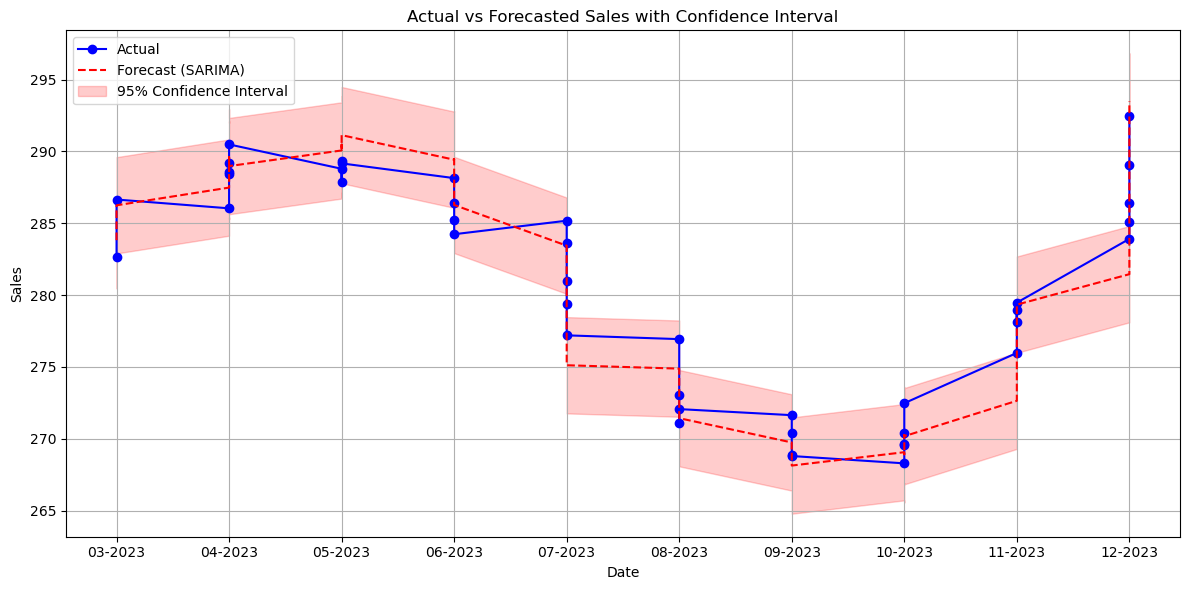


🧠  Rueben Patil | AutoForecast Suite — Intelligent Time Series Predictions

📅 Future Forecast for the next 42 periods using SARIMA:
   Date   Forecast  Lower Bound  Upper Bound
01-2024 283.824463   280.474349   287.174577
01-2024 286.251431   282.901317   289.601545
01-2024 287.484081   284.133967   290.834196
01-2024 288.760794   285.410680   292.110908
02-2024 288.639011   285.288897   291.989125
02-2024 289.596673   286.246559   292.946787
02-2024 288.980101   285.629987   292.330216
02-2024 290.069026   286.718912   293.419140
03-2024 290.471512   287.121398   293.821626
03-2024 290.209557   286.859443   293.559671
03-2024 291.134093   287.783979   294.484207
03-2024 289.424649   286.074535   292.774763
04-2024 289.445903   286.095789   292.796017
04-2024 287.782250   284.432136   291.132364
04-2024 286.274917   282.924803   289.625031
04-2024 283.442628   280.092514   286.792742
04-2024 280.579424   277.229310   283.929538
05-2024 279.004166   275.654052   282.354280
05-2024 277.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import acf, pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error
import torch
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE
import optuna
from pytorch_lightning.callbacks import EarlyStopping
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
from scipy.stats import skew
from itertools import combinations
import sys
import warnings

warnings.filterwarnings("ignore")

# Load dataset
file_path = r"C:\Users\ADMIN\Downloads\weekly_sales_5_years.csv"
df = pd.read_csv(file_path)

# Try parsing weekly-compatible date formats
parsed = False
formats_to_try = ["%Y-%m-%d", "%d-%m-%Y", "%Y/%m/%d", "%d/%m/%Y"]

for fmt in formats_to_try:
    try:
        df["Week"] = pd.to_datetime(df["Week"], format=fmt)
        parsed = True
        break
    except ValueError:
        continue

if not parsed:
    try:
        df["Week"] = pd.to_datetime(df["Week"], infer_datetime_format=True)
        parsed = True
    except Exception as e:
        print("❌ Unable to parse the 'Week' column. Please ensure it has consistent weekly date format.")
        raise e

# Set the parsed 'Week' column as index
df.set_index("Week", inplace=True)
print("✅ Week column successfully parsed and set as index.")

# External features
target_column = "Sales"
external_features = [col for col in df.columns if col != target_column]
df[external_features] = df[external_features].fillna(0)

# Check data length (minimum 2 years = 104 weeks recommended)
if len(df) < 104:
    print("❌ Insufficient data. Please provide at least 2 years (104 weeks) of data.")
    sys.exit()

# Handle missing values
if df[target_column].isnull().sum() > 0:
    print("⚠️ Missing values detected. Applying forward fill (ffill).")
    df[target_column].fillna(method='ffill', inplace=True)

    if df[target_column].isnull().sum() > 0:
        print("⚠️ Some values are still missing. Applying linear interpolation.")
        df[target_column].interpolate(method='linear', inplace=True)

    print("⚠️ Forecast accuracy may be affected due to Existence of Missing Values.")

# Check skewness
from scipy.stats import skew
skewness = skew(df[target_column])
print(f"Skewness: {skewness}")

if abs(skewness) > 1:
    print("⚠️ Skewness is high, applying log transformation.")
    df[target_column] = np.log(df[target_column] + 1)
else:
    print("✅ Skewness is acceptable. No transformation applied.")

# Detect & treat outliers using IQR
Q1, Q3 = df[target_column].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = df[(df[target_column] < lower_bound) | (df[target_column] > upper_bound)]

if not outliers.empty:
    print("⚠️ Outliers detected. Replacing with median.")
    df.loc[df[target_column] < lower_bound, target_column] = df[target_column].median()
    df.loc[df[target_column] > upper_bound, target_column] = df[target_column].median()

# Generate lag features (up to 52 weeks)
for lag in range(1, 53):
    df[f'lag_{lag}'] = df[target_column].shift(lag)
df.dropna(inplace=True)

# ACF/PACF selection
from statsmodels.tsa.stattools import acf, pacf
max_lags = min(52, len(df) // 2 - 1)
acf_values = acf(df[target_column], nlags=max_lags)[1:]
pacf_values = pacf(df[target_column], nlags=max_lags)[1:]
selected_lags = [i + 1 for i, (a, p) in enumerate(zip(acf_values, pacf_values)) if abs(a) > 0.2 or abs(p) > 0.2]

if not selected_lags:
    selected_lags = list(range(1, 53))

# VIF filtering
from statsmodels.stats.outliers_influence import variance_inflation_factor
selected_features = [f'lag_{lag}' for lag in selected_lags]
while len(selected_features) > 1:
    vif_data = pd.DataFrame()
    vif_data['Feature'] = selected_features
    vif_data['VIF'] = [variance_inflation_factor(df[selected_features].values, i) for i in range(len(selected_features))]

    max_vif = vif_data['VIF'].max()
    if max_vif > 5:
        selected_features.remove(vif_data.loc[vif_data['VIF'].idxmax(), 'Feature'])
    else:
        break

# RMSE-based lag selection
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def select_best_lags(train_features, test_features, train_target, test_target, model, max_lags=5):
    best_rmse, best_lags = float("inf"), None
    all_lags = [col for col in train_features.columns if col.startswith("lag_")]

    for r in range(1, min(len(all_lags), max_lags) + 1):
        for lag_subset in combinations(all_lags, r):
            try:
                train_subset = train_features[list(lag_subset)]
                test_subset = test_features[list(lag_subset)]
                model.fit(train_subset, train_target)
                predictions = model.predict(test_subset)
                rmse = np.sqrt(mean_squared_error(test_target, predictions))
                if rmse < best_rmse:
                    best_rmse, best_lags = rmse, list(lag_subset)
            except Exception:
                continue
    return best_lags if best_lags else all_lags

# Train/test split
split_index = int(len(df) * 0.8)
train_df, test_df = df.iloc[:split_index], df.iloc[split_index:]
train_features = train_df[selected_features]
test_features = test_df[selected_features]
train_target = train_df[target_column]
test_target = test_df[target_column]

model = LinearRegression()
best_lags = select_best_lags(train_features, test_features, train_target, test_target, model)
selected_features = best_lags

# Final Lasso Filtering
from sklearn.linear_model import Lasso
X = df[selected_features]
y = df[target_column]
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
selected_features = [feature for feature, coef in zip(selected_features, lasso.coef_) if coef != 0]

# ✅ Apply rolling statistics dynamically (optimized for RMSE)
best_window = 3  # Start with 3 weeks
best_rmse = float("inf")

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

for window in range(3, 37):
    rolling_mean = train[target_column].rolling(window=window, min_periods=1).mean()
    rmse = np.sqrt(mean_squared_error(test[target_column], rolling_mean[-len(test):]))
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window

print(f"✅ Best rolling window (weekly): {best_window}")
df[target_column] = df[target_column].rolling(window=best_window, min_periods=1).mean()

# ✅ Recreate train-test split post rolling
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
train_features, test_features = train[selected_features], test[selected_features]
train_target, test_target = train[target_column], test[target_column]

# ✅ Evaluation metrics for all models
def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

def mean_forecast_bias(actual, forecast):
    return np.mean(forecast - actual)

def evaluate_model(actual, forecast):
    return smape(actual, forecast), mean_forecast_bias(actual, forecast)

# ✅ TFT-like Dense Model with Optuna tuning
def run_tft(train_features, test_features, train_target, test_target):
    def objective(trial):
        units = trial.suggest_int('units', 32, 256)
        dropout = trial.suggest_float('dropout', 0.1, 0.5)

        model = Sequential([
            Dense(units, activation='relu', input_shape=(train_features.shape[1],)),
            Dropout(dropout),
            Dense(units // 2, activation='relu'),
            Dropout(dropout),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(train_features, train_target, epochs=50, batch_size=16, verbose=0)
        preds = model.predict(test_features).flatten()
        return smape(test_target, preds)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)

    best_params = study.best_params
    model = Sequential([
        Dense(best_params['units'], activation='relu', input_shape=(train_features.shape[1],)),
        Dropout(best_params['dropout']),
        Dense(best_params['units'] // 2, activation='relu'),
        Dropout(best_params['dropout']),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(train_features, train_target, epochs=50, batch_size=16, verbose=0)
    optimized_preds = model.predict(test_features).flatten()

    baseline_model = Sequential([
        Dense(128, activation='relu', input_shape=(train_features.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    baseline_model.compile(optimizer='adam', loss='mse')
    baseline_model.fit(train_features, train_target, epochs=50, batch_size=16, verbose=0)
    baseline_preds = baseline_model.predict(test_features).flatten()

    smape_base, mfb_base = evaluate_model(test_target, baseline_preds)
    smape_opt, mfb_opt = evaluate_model(test_target, optimized_preds)

    return optimized_preds if smape_opt < smape_base and abs(mfb_opt) < abs(mfb_base) else baseline_preds

# ✅ LSTM Model with Optuna
def run_lstm(train_features, test_features, train_target, test_target):
    train_X = np.asarray(train_features).reshape(train_features.shape[0], train_features.shape[1], 1)
    test_X = np.asarray(test_features).reshape(test_features.shape[0], test_features.shape[1], 1)

    train_y = np.asarray(train_target).reshape(-1, 1)
    test_y = np.asarray(test_target).reshape(-1, 1)

    def objective(trial):
        n_units = trial.suggest_int("n_units", 16, 128)
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

        model = Sequential([
            LSTM(n_units, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], 1)),
            Dropout(dropout_rate),
            LSTM(n_units, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        model.fit(train_X, train_y, epochs=50, batch_size=16, verbose=0)
        predictions = model.predict(test_X).flatten()
        return smape(test_y, predictions)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    best_trial = study.best_trial
    best_model = Sequential([
        LSTM(best_trial.params["n_units"], activation='relu', return_sequences=True, input_shape=(train_X.shape[1], 1)),
        Dropout(best_trial.params["dropout_rate"]),
        LSTM(best_trial.params["n_units"], activation='relu'),
        Dense(1)
    ])
    best_model.compile(optimizer=Adam(learning_rate=best_trial.params["learning_rate"]), loss='mse')
    best_model.fit(train_X, train_y, epochs=50, batch_size=16, verbose=0)

    final_predictions = best_model.predict(test_X).flatten()
    return final_predictions

# ✅ GRU Model with Optuna and dynamic baseline comparison
def run_gru(train_features, test_features, train_target, test_target):
    train_X = np.asarray(train_features).reshape(train_features.shape[0], train_features.shape[1], 1)
    test_X = np.asarray(test_features).reshape(test_features.shape[0], test_features.shape[1], 1)

    train_y = np.asarray(train_target).reshape(-1, 1)
    test_y = np.asarray(test_target).reshape(-1, 1)

    def objective(trial):
        n_units = trial.suggest_int("n_units", 16, 128)
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

        model = Sequential([
            GRU(n_units, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], 1)),
            Dropout(dropout_rate),
            GRU(n_units, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        model.fit(train_X, train_y, epochs=50, batch_size=16, verbose=0)
        predictions = model.predict(test_X).flatten()
        return smape(test_y, predictions)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    best_trial = study.best_trial
    best_model = Sequential([
        GRU(best_trial.params["n_units"], activation='relu', return_sequences=True, input_shape=(train_X.shape[1], 1)),
        Dropout(best_trial.params["dropout_rate"]),
        GRU(best_trial.params["n_units"], activation='relu'),
        Dense(1)
    ])
    best_model.compile(optimizer=Adam(learning_rate=best_trial.params["learning_rate"]), loss='mse')
    best_model.fit(train_X, train_y, epochs=50, batch_size=16, verbose=0)

    baseline_model = Sequential([
        GRU(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], 1)),
        GRU(50, activation='relu'),
        Dense(1)
    ])
    baseline_model.compile(optimizer='adam', loss='mse')
    baseline_model.fit(train_X, train_y, epochs=50, batch_size=16, verbose=0)

    best_preds = best_model.predict(test_X).flatten()
    baseline_preds = baseline_model.predict(test_X).flatten()

    if smape(test_y, best_preds) < smape(test_y, baseline_preds) and abs(mean_forecast_bias(test_y, best_preds)) < abs(mean_forecast_bias(test_y, baseline_preds)):
        return best_preds
    else:
        return baseline_preds

# Determine frequency-based seasonality
def get_seasonal_period(data):
    inferred_freq = pd.infer_freq(data.index)
    if inferred_freq in ['W', 'W-MON', 'W-SUN']:
        return 52  # Weekly data
    elif inferred_freq in ['MS', 'M']:
        return 12  # Monthly data
    else:
        return max(2, min(12, len(data) // 2))  # Fallback

# Function to calculate SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Function to calculate MFB
def mfb(y_true, y_pred):
    return 100 * np.mean((y_pred - y_true) / y_true)

# ARIMA
def run_arima(train, test):
    best_loss, best_order = float("inf"), None
    lambda_mfb = 0.5

    for p in range(3):
        for d in range(2):
            for q in range(3):
                try:
                    model = ARIMA(train, order=(p, d, q)).fit()
                    pred = model.forecast(steps=len(test))
                    smape_score = smape(test, pred)
                    mfb_score = abs(mfb(test, pred))
                    loss = smape_score + lambda_mfb * mfb_score
                    if loss < best_loss:
                        best_loss, best_order = loss, (p, d, q)
                except:
                    continue
    final_model = ARIMA(train, order=best_order).fit()
    return final_model.forecast(steps=len(test))

# SARIMA
def run_sarima(train, test):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    seasonal_period = get_seasonal_period(train)

    for p in range(3):
        for d in range(2):
            for q in range(3):
                for P in range(2):
                    for D in range(2):
                        for Q in range(2):
                            try:
                                model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period)).fit()
                                pred = model.forecast(steps=len(test))
                                score = smape(test, pred) + abs(mfb(test, pred))
                                if score < best_score:
                                    best_score, best_order, best_seasonal_order = score, (p, d, q), (P, D, Q, seasonal_period)
                            except:
                                continue
    return SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order).fit().forecast(steps=len(test))

# ETS
def run_ets(train, test):
    seasonal_period = get_seasonal_period(train)

    def objective(trial):
        trend = trial.suggest_categorical("trend", ["add", "mul", None])
        seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])
        seasonal_periods = trial.suggest_int("seasonal_periods", 2, min(52, len(train) // 2))
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
            return smape(test, model.forecast(len(test)))
        except:
            return float("inf")

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    best = study.best_params
    try:
        best_model = ExponentialSmoothing(train, trend=best["trend"], seasonal=best["seasonal"], seasonal_periods=best["seasonal_periods"]).fit()
    except:
        best_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_period).fit()

    return best_model.forecast(len(test))

# Holt-Winters
def run_holt_winters(train, test):
    train_series = pd.Series(train)
    seasonal_period = get_seasonal_period(train)

    def objective(trial):
        trend = trial.suggest_categorical("trend", ["add", "mul", None])
        seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])
        seasonal_periods = trial.suggest_int("seasonal_periods", 2, min(52, len(train) // 2))
        sl = trial.suggest_float("smoothing_level", 0.01, 1.0)
        ss = trial.suggest_float("smoothing_slope", 0.01, 1.0)
        seas = trial.suggest_float("smoothing_seasonal", 0.01, 1.0)

        try:
            model = ExponentialSmoothing(train_series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
            fitted = model.fit(smoothing_level=sl, smoothing_slope=ss, smoothing_seasonal=seas)
            return smape(test, fitted.forecast(len(test)))
        except:
            return float("inf")

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20, timeout=60)

    best = study.best_params
    model = ExponentialSmoothing(train_series, trend=best["trend"], seasonal=best["seasonal"], seasonal_periods=best["seasonal_periods"])
    fitted = model.fit(smoothing_level=best["smoothing_level"], smoothing_slope=best["smoothing_slope"], smoothing_seasonal=best["smoothing_seasonal"])
    return fitted.forecast(len(test))

# ML models
def run_ml_model(model, train, test, train_features, test_features):
    model.fit(train_features, train)
    base_pred = model.predict(test_features)
    base_score = smape(test, base_pred)

    def objective(trial):
        param_grid = {
            "RandomForestRegressor": {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
                "max_depth": trial.suggest_int("max_depth", 3, 20),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            },
            "XGBRegressor": {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
                "max_depth": trial.suggest_int("max_depth", 3, 20),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            },
            "LGBMRegressor": {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
                "max_depth": trial.suggest_int("max_depth", 3, 20),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            },
            "CatBoostRegressor": {
                "iterations": trial.suggest_int("iterations", 50, 300, step=50),
                "depth": trial.suggest_int("depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            },
            "SVR": {
                "C": trial.suggest_float("C", 0.1, 10),
                "epsilon": trial.suggest_float("epsilon", 0.01, 1),
                "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "poly"]),
            },
            "KNeighborsRegressor": {
                "n_neighbors": trial.suggest_int("n_neighbors", 2, 20),
                "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            },
        }

        model_class = model.__class__.__name__
        tuned = model.__class__(**param_grid.get(model_class, {}))
        tuned.fit(train_features, train)
        return smape(test, tuned.predict(test_features))

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20, timeout=120)

    best_params = study.best_params
    tuned_model = model.__class__(**{k: v for k, v in best_params.items() if k in model.get_params()})
    tuned_model.fit(train_features, train)
    tuned_pred = tuned_model.predict(test_features)

    return tuned_pred if smape(test, tuned_pred) < base_score else base_pred

# Prophet
def run_prophet(train, test):
    # If train/test are Series, convert to Prophet-compatible DataFrame
    if isinstance(train, pd.Series):
        df_train = pd.DataFrame({'ds': train.index, 'y': train.values})
    else:
        df_train = train.rename(columns={train.columns[0]: 'ds', train.columns[1]: 'y'})

    if isinstance(test, pd.Series):
        df_test = pd.DataFrame({'ds': test.index, 'y': test.values})
    else:
        df_test = test.rename(columns={test.columns[0]: 'ds', test.columns[1]: 'y'})

    model = Prophet()

    # Optional: Add regressors if present
    if not isinstance(train, pd.Series) and 'holiday' in train.columns:
        df_train['holiday'] = train['holiday'].values
        model.add_regressor('holiday')

    model.fit(df_train)

    # Infer frequency or fall back to weekly
    freq = pd.infer_freq(df_train['ds']) or "W"
    future = model.make_future_dataframe(periods=len(df_test), freq=freq)

    # Add regressors to future if used
    if not isinstance(test, pd.Series) and 'holiday' in test.columns:
        future['holiday'] = test['holiday'].values

    forecast = model.predict(future)

    return forecast[['yhat']].iloc[-len(df_test):].values.flatten()

# SMAPE
def smape(actual, predicted):
    return 100 * np.mean(np.abs(predicted - actual) / ((np.abs(actual) + np.abs(predicted)) / 2))

# MFB
def mfb(actual, predicted):
    return np.sum(predicted - actual) / np.sum(actual)

# Model Evaluation Pipeline
def evaluate_models(train, test, train_features, test_features):
    models = {
        "ARIMA": run_arima(train, test),
        "SARIMA": run_sarima(train, test),
        "ETS": run_ets(train, test),
        "Holt-Winters": run_holt_winters(train, test),
        "Random Forest": run_ml_model(RandomForestRegressor(n_estimators=100), train, test, train_features, test_features),
        "XGBoost": run_ml_model(XGBRegressor(), train, test, train_features, test_features),
        "LightGBM": run_ml_model(LGBMRegressor(), train, test, train_features, test_features),
        "CatBoost": run_ml_model(CatBoostRegressor(verbose=0), train, test, train_features, test_features),
        "SVR": run_ml_model(SVR(), train, test, train_features, test_features),
        "KNN": run_ml_model(KNeighborsRegressor(), train, test, train_features, test_features),
        "LSTM": run_lstm(train_features.values.reshape(-1, train_features.shape[1], 1),
                         test_features.values.reshape(-1, test_features.shape[1], 1),
                         train.values, test.values).flatten(),
        "GRU":  run_gru(train_features.values.reshape(-1, train_features.shape[1], 1),
                        test_features.values.reshape(-1, test_features.shape[1], 1),
                        train.values, test.values).flatten(),
        "TFT": run_tft(train_features, test_features, train, test),
        "Prophet": run_prophet(train, test)
    }

    smape_scores = {model: smape(test, pred) for model, pred in models.items()}
    mfb_scores = {model: mfb(test, pred) for model, pred in models.items()}

    best_smape = min(smape_scores.values())
    smape_threshold = 1.5 * best_smape
    selected_models = {
        model: pred for model, pred in models.items()
        if smape_scores[model] <= smape_threshold and abs(mfb_scores[model]) <= 0.1
    }

    print("\n✅ Models Used in Simple Average:")
    for model in selected_models:
        print(f"- {model}")

    simple_avg_forecast = np.mean(list(selected_models.values()), axis=0)
    smape_simple_avg = smape(test, simple_avg_forecast)
    mfb_simple_avg = mfb(test, simple_avg_forecast)

    array_based_models = {
        model: pred for model, pred in models.items()
        if isinstance(pred, np.ndarray)
    }
    inverse_smape = {
        model: 1 / smape_scores[model] for model in array_based_models if smape_scores[model] > 0
    }
    total_weight = sum(inverse_smape.values())
    weights = {model: weight / total_weight for model, weight in inverse_smape.items()}

    weighted_avg_forecast = sum(weights[model] * array_based_models[model] for model in array_based_models)
    smape_weighted_avg = smape(test, weighted_avg_forecast)
    mfb_weighted_avg = mfb(test, weighted_avg_forecast)

    smape_scores["Simple Average"] = smape_simple_avg
    smape_scores["Weighted Average"] = smape_weighted_avg
    mfb_scores["Simple Average"] = mfb_simple_avg
    mfb_scores["Weighted Average"] = mfb_weighted_avg

    print("\n🔄 Evaluating Hybrid Models...")
    hybrid_model = None

    if smape_scores["Weighted Average"] < best_smape:
        hybrid_model = "Weighted Average"
    else:
        best_stat_model = min(["ARIMA", "SARIMA", "ETS", "Holt-Winters"], key=lambda m: smape_scores.get(m, float("inf")))
        best_ml_model = min(["Random Forest", "XGBoost", "LightGBM", "CatBoost", "SVR", "KNN"], key=lambda m: smape_scores.get(m, float("inf")))
        best_dl_model = min(["LSTM", "GRU", "TFT"], key=lambda m: smape_scores.get(m, float("inf")))

        if best_stat_model and best_ml_model:
            hybrid_forecast = 0.5 * models[best_stat_model] + 0.5 * models[best_ml_model]
            smape_hybrid = smape(test, hybrid_forecast)
            print(f"📊 Hybrid {best_stat_model} + {best_ml_model}: SMAPE = {smape_hybrid:.4f}")
            if smape_hybrid < best_smape:
                hybrid_model = f"{best_stat_model} + {best_ml_model}"
                models[hybrid_model] = hybrid_forecast
                smape_scores[hybrid_model] = smape_hybrid

        elif best_ml_model and best_dl_model:
            hybrid_forecast = 0.5 * models[best_ml_model] + 0.5 * models[best_dl_model]
            smape_hybrid = smape(test, hybrid_forecast)
            print(f"📊 Hybrid {best_ml_model} + {best_dl_model}: SMAPE = {smape_hybrid:.4f}")
            if smape_hybrid < best_smape:
                hybrid_model = f"{best_ml_model} + {best_dl_model}"
                models[hybrid_model] = hybrid_forecast
                smape_scores[hybrid_model] = smape_hybrid

    best_model = min(smape_scores, key=smape_scores.get)

    return models, smape_scores, mfb_scores, best_model, simple_avg_forecast, weighted_avg_forecast

# --------------------------
# Run Pipeline
# --------------------------
if __name__ == "__main__":
    models, smape_scores, mfb_scores, best_model, simple_avg_forecast, weighted_avg_forecast = evaluate_models(
        train[target_column], test[target_column], train_features, test_features
    )

    print("\n🔹 SMAPE Scores:")
    for model, score in smape_scores.items():
        print(f"{model}: {score:.4f}")

    print("\n🔹 MFB Scores:")
    for model, score in mfb_scores.items():
        print(f"{model}: {score:.4f}")

    print(f"\n✅ Best Model: {best_model} (SMAPE: {smape_scores[best_model]:.4f}, MFB: {mfb_scores[best_model]:.4f})")

    while True:
        selected_model = input("\nEnter the model name you want to use for forecasting (from the above list): ").strip()
        if selected_model in models or selected_model in ["Simple Average", "Weighted Average"]:
            break
        print("Invalid model selection. Please enter a valid model name from the list.")

    forecast_horizon = len(test)
    chosen_forecast = None
    future_forecast_values = None

    if selected_model == "Simple Average":
        chosen_forecast = simple_avg_forecast
        future_forecast_values = chosen_forecast[-forecast_horizon:]

    elif selected_model == "Weighted Average":
        chosen_forecast = weighted_avg_forecast
        future_forecast_values = chosen_forecast[-forecast_horizon:]

    elif selected_model in models:
        model_output = models[selected_model]
        if selected_model == "Prophet":
            chosen_forecast = model_output['yhat'][:len(test)]
            future_forecast_values = model_output['yhat'][-forecast_horizon:]
        elif isinstance(model_output, dict) and "test" in model_output and "future" in model_output:
            chosen_forecast = model_output["test"]
            future_forecast_values = model_output["future"]
        else:
            chosen_forecast = model_output
            future_forecast_values = chosen_forecast[-forecast_horizon:]
    else:
        print("⚠️ Invalid model selection. Using best model.")
        chosen_forecast = models[best_model]
        future_forecast_values = chosen_forecast[-forecast_horizon:]

    test.index = pd.to_datetime(test.index)
    formatted_test_index = test.index.strftime('%m-%Y')

    residuals = test[target_column] - chosen_forecast
    std_dev = np.std(residuals)
    z_score = 1.96
    lower_bound = chosen_forecast - (z_score * std_dev)
    upper_bound = chosen_forecast + (z_score * std_dev)

    forecast_df = pd.DataFrame({
        "Date": formatted_test_index,
        "Actual": test[target_column].values,
        "Forecast": chosen_forecast,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound
    })

    print("\n📊 Actual vs Forecast (Test Dataset) with Confidence Interval:")
    print(forecast_df.to_string(index=False))

    last_test_date = test.index[-1]
    future_dates = pd.date_range(start=last_test_date, periods=forecast_horizon + 1, freq='W-MON')[1:]
    formatted_future_dates = future_dates.strftime('%m-%Y')

    future_lower_bound = future_forecast_values - (z_score * std_dev)
    future_upper_bound = future_forecast_values + (z_score * std_dev)

    future_forecast_df = pd.DataFrame({
        "Date": formatted_future_dates,
        "Forecast": future_forecast_values,
        "Lower Bound": future_lower_bound,
        "Upper Bound": future_upper_bound
    })

    plt.figure(figsize=(12, 6))
    plt.plot(formatted_test_index, test[target_column], label="Actual", marker="o", linestyle="-", color="blue")
    plt.plot(formatted_test_index, chosen_forecast, label=f"Forecast ({selected_model})", linestyle="--", color="red")
    plt.fill_between(formatted_test_index, lower_bound, upper_bound, color="red", alpha=0.2, label="95% Confidence Interval")

    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title("Actual vs Forecasted Sales with Confidence Interval")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("🧠  RP&KP | AutoForecast Suite — Intelligent Time Series Predictions".center(60))
    print("="*80)
    
    print(f"\n📅 Future Forecast for the next {forecast_horizon} periods using {selected_model}:")
    print(future_forecast_df.to_string(index=False))
    print("="*80)